In [17]:
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import read_vtk as ath

In [12]:
datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin/test11_10-large/joined/'
datafiles = glob.glob(datapath + '*.vtk')
snapfile = datafiles[0]

In [19]:
data = ath.vtk(snapfile, out_dt = 1.0)
data['gamma1'] = 1./np.sqrt(1.-data['vel1']**2)
data.keys()

dict_keys(['Time', 'x1f', 'x2f', 'x3f', 'x1v', 'x2v', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3', 'Bcc1', 'Bcc2', 'Bcc3', 'gamma1'])

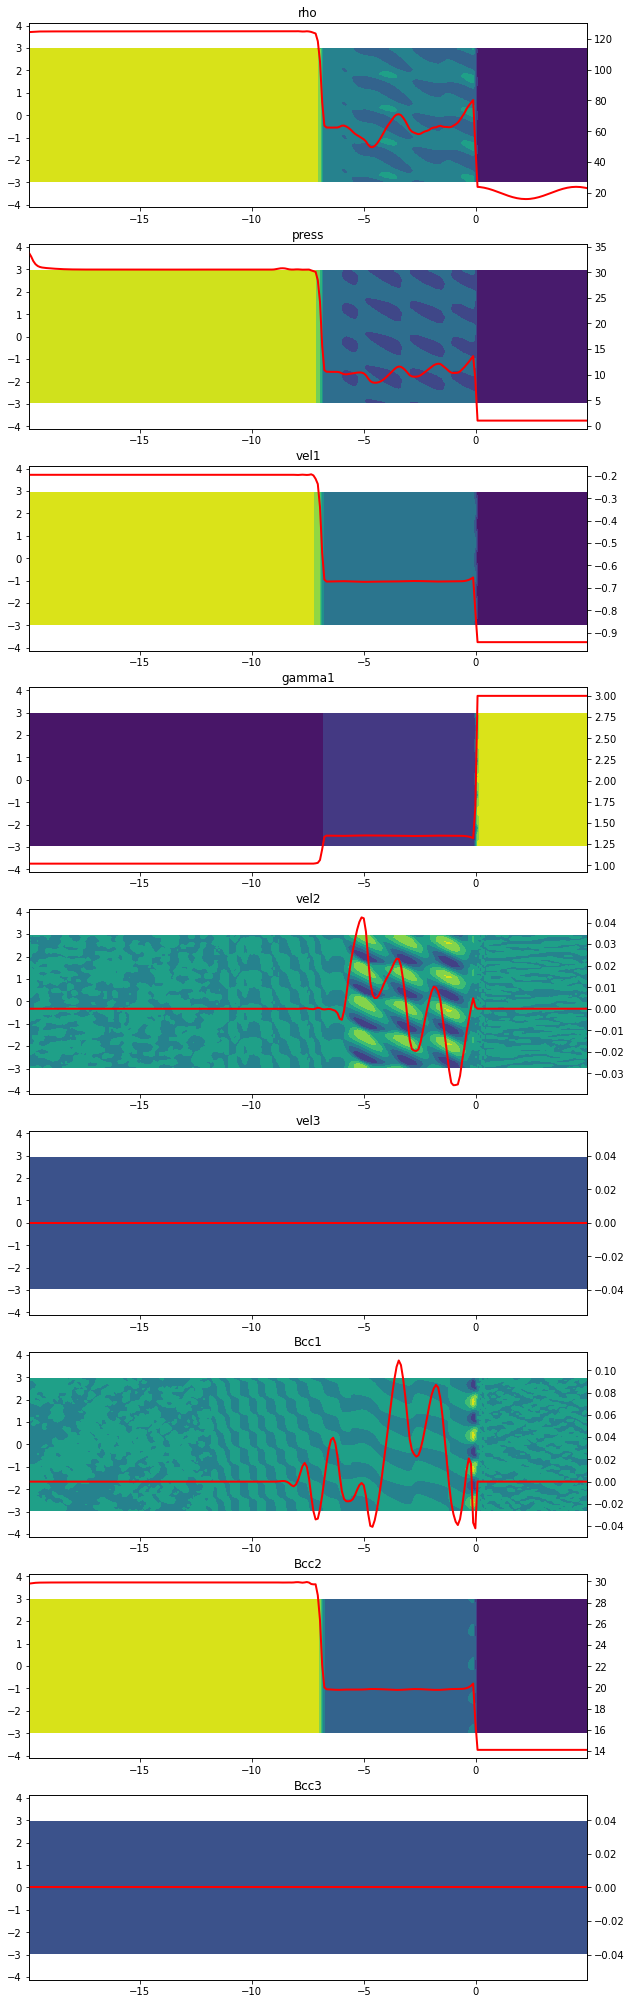

In [26]:
quantities = ['rho', 'press', 'vel1', 'gamma1', 'vel2', 'vel3', 'Bcc1', 'Bcc2', 'Bcc3']
n_quantities = len(quantities)

fig = plt.figure(figsize=(10,4*n_quantities))
gs = gridspec.GridSpec(n_quantities,1)

for idx, quantity in zip(range(n_quantities), quantities):
    plt.subplot(gs[idx, 0])
    plt.contourf(data['x1v'], data['x2v'], data[quantity])
    plt.gca().set_aspect(1)
    plt.title(quantity)
    ax = plt.gca().twinx()
    ax.plot(data['x1v'], data[quantity][int(data[quantity].shape[0]/2),:], color='r', linewidth=2, ls='-')
    
plt.show()
plt.close()

vel1 seems best for shock detection at these parameters..

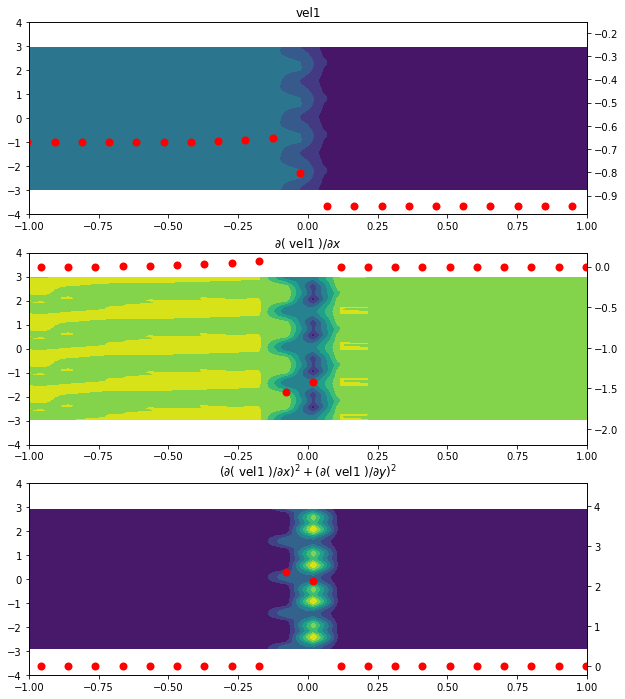

In [80]:
quantity = 'vel1'
xlim = [-1,1]
ylim = [-4,4]

fig = plt.figure(figsize=(10,4*3))
gs = gridspec.GridSpec(3,1)

plt.subplot(gs[0, 0])
plt.contourf(data['x1v'], data['x2v'], data[quantity])
#plt.gca().set_aspect(1)
plt.title(quantity)
plt.xlim(*xlim)
plt.ylim(*ylim)
ax = plt.gca().twinx()
ax.scatter(data['x1v'], data[quantity][int(data[quantity].shape[0]/2),:], color='r', linewidth=2, ls='-')
#plt.xlim(*xlim)

# 1D derivative
dx = data['x1v'][1:] - data['x1v'][:-1]
x_avg = 0.5* (data['x1v'][1:] + data['x1v'][:-1])
dq = data[quantity][:,1:] - data[quantity][:,:-1]
dq_dx = dq / dx

plt.subplot(gs[1, 0])
plt.contourf(x_avg, data['x2v'], dq_dx)
#plt.gca().set_aspect(1)
plt.title('$\\partial($ ' + quantity + ' $) / \\partial x$')
plt.xlim(*xlim)
plt.ylim(*ylim)
ax = plt.gca().twinx()
ax.scatter(x_avg, dq_dx[int(data[quantity].shape[0]/2),:], color='r', linewidth=2, ls='-')
#plt.xlim(*xlim)

# 2D derivative
dy = data['x2v'][1:] - data['x2v'][:-1]
y_avg = 0.5* (data['x2v'][1:] + data['x2v'][:-1])
dq = data[quantity][1:,:] - data[quantity][:-1,:]
dq_dy = (dq.transpose() / dy).transpose()

dq_dx_avg = 0.5*(dq_dx[1:,:] + dq_dx[:-1,:])
dq_dy_avg = 0.5*(dq_dy[:,1:] + dq_dy[:,:-1])
gradient = dq_dx_avg**2 + dq_dy_avg**2

plt.subplot(gs[2, 0])
plt.contourf(x_avg, y_avg, gradient)
#plt.gca().set_aspect(1)
plt.title('$(\\partial($ ' + quantity + ' $) / \\partial x)^2 + (\\partial($ ' + quantity + ' $) / \\partial y)^2$')
plt.xlim(*xlim)
plt.ylim(*ylim)
ax = plt.gca().twinx()
ax.scatter(x_avg, gradient[int(data[quantity].shape[0]/2),:], color='r', linewidth=2, ls='-')
#plt.xlim(*xlim)
    
plt.show()
plt.close()

Let us use the gradient norm to take into account the 2D character of our shock structure...

In [155]:
def find_local_maxima_row (x, y, row, cutoff=np.inf, fit=True, calc_angle=False, dq_dx=None, min_sin_angle=(1./np.sqrt(3.))):
    result = []
    indices = np.where(row > cutoff)[0]
    for consecutive in np.split(indices, np.where(np.diff(indices) != 1)[0]+1):
        values = row[consecutive]
        idx_max = np.argmax(values) + consecutive[0]
        if fit:
            x_max = np.sum(row[(idx_max-1):(idx_max+2)] * x[(idx_max-1):(idx_max+2)]) / np.sum(row[(idx_max-1):(idx_max+2)])
        else:
            x_max = x[idx_max]
        if calc_angle:
            sin_angle = np.abs(dq_dx[idx_max] / np.sqrt(row[idx_max]))
            # cap the angle at a lower limit to avoid division by 0
            sin_angle = np.maximum(sin_angle, min_sin_angle)
        else:
            sin_angle = None
        result.append([x_max, y, sin_angle])
    return result

def find_shock (data, quantity, dq_dx_cutoff=0.25, fit=True, derivative_2D=False):
    # compute the derivative
    dx = data['x1v'][1:] - data['x1v'][:-1]
    x_avg = 0.5* (data['x1v'][1:] + data['x1v'][:-1])
    dq = data[quantity][:,1:] - data[quantity][:,:-1]
    dq_dx = dq / dx
    if derivative_2D:
        dy = data['x2v'][1:] - data['x2v'][:-1]
        y_avg = 0.5* (data['x2v'][1:] + data['x2v'][:-1])
        dq = data[quantity][1:,:] - data[quantity][:-1,:]
        dq_dy = (dq.transpose() / dy).transpose()

        dq_dx_avg = 0.5*(dq_dx[1:,:] + dq_dx[:-1,:])
        dq_dy_avg = 0.5*(dq_dy[:,1:] + dq_dy[:,:-1])
        
        gradient = dq_dx_avg**2 + dq_dy_avg**2
            
    else:
        gradient = -dq_dx
        y_avg = data['x2v']
        dq_dy_avg = np.ones(len(y_avg)) * np.nan
        
    # this will calculate a list of points (x,y) corresponding to shock detections
    shocks = sum(list(map(lambda row_y : find_local_maxima_row(x=x_avg, y=row_y[1], row=row_y[0], cutoff=dq_dx_cutoff, fit=fit, calc_angle=derivative_2D, dq_dx=row_y[2]), zip(gradient,y_avg,dq_dx_avg))),[])
    return np.array(shocks)

In [156]:
shocks = find_shock(data, 'vel1', derivative_2D=True).transpose()
angles = 1./np.abs(shocks[2])
angles = (angles - np.min(angles)) / (np.max(angles) - np.min(angles)) + 0.1
print(angles)

[0.10091502 0.37076036 0.10141219 0.80428392 0.10170134 1.08372779
 0.10119494 1.09999696 0.10060256 0.60070709 0.1000647  0.38548251
 0.10002239 0.2885337  0.10039773 0.15426674 0.10102606 0.19548891
 0.10158626 0.56361441 0.10161654 0.61600721 0.10102067 0.61712046
 0.10044867 0.73561129 0.10004501 1.04912053 0.1        0.54001127
 0.10031889 0.10065681 0.1009149  0.37074129 0.10141211 0.80428801
 0.10170142 1.08372713 0.10119494 1.1        0.10060256 0.60069733
 0.1000647  0.38549606 0.10002238 0.28852298 0.10039777 0.15427021
 0.10102606 0.19549995 0.10158618 0.56359478 0.10161662 0.61600694
 0.10102067 0.61713106 0.10044867 0.7356052  0.10004501 1.04913018
 0.1        0.53999739 0.10031889 0.1006577  0.1009149  0.37075228
 0.10141219 0.80428392 0.10170134 1.08372779 0.10119494 1.09999696
 0.10060256 0.60070247 0.1000647  0.38549424 0.10002239 0.28852136
 0.10039773 0.15427021 0.10102606 0.19549876 0.10158618 0.56359426
 0.10161662 0.61600666 0.10102067 0.61712576 0.10044867 0.7356

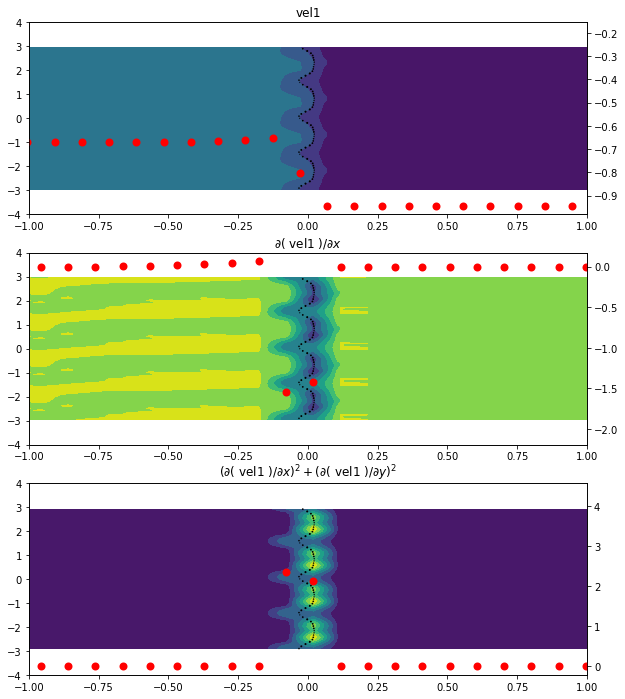

In [159]:
quantity = 'vel1'
xlim = [-1,1]
ylim = [-4,4]

fig = plt.figure(figsize=(10,4*3))
gs = gridspec.GridSpec(3,1)

plt.subplot(gs[0, 0])
plt.contourf(data['x1v'], data['x2v'], data[quantity])
#plt.gca().set_aspect(1)
plt.title(quantity)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.scatter(shocks[0], shocks[1], color='k', s=angles)
ax = plt.gca().twinx()
ax.scatter(data['x1v'], data[quantity][int(data[quantity].shape[0]/2),:], color='r', linewidth=2, ls='-')
#plt.xlim(*xlim)

# 1D derivative
dx = data['x1v'][1:] - data['x1v'][:-1]
x_avg = 0.5* (data['x1v'][1:] + data['x1v'][:-1])
dq = data[quantity][:,1:] - data[quantity][:,:-1]
dq_dx = dq / dx

plt.subplot(gs[1, 0])
plt.contourf(x_avg, data['x2v'], dq_dx)
#plt.gca().set_aspect(1)
plt.title('$\\partial($ ' + quantity + ' $) / \\partial x$')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.scatter(shocks[0], shocks[1], color='k', s=angles)
ax = plt.gca().twinx()
ax.scatter(x_avg, dq_dx[int(data[quantity].shape[0]/2),:], color='r', linewidth=2, ls='-')
#plt.xlim(*xlim)

# 2D derivative
dy = data['x2v'][1:] - data['x2v'][:-1]
y_avg = 0.5* (data['x2v'][1:] + data['x2v'][:-1])
dq = data[quantity][1:,:] - data[quantity][:-1,:]
dq_dy = (dq.transpose() / dy).transpose()

dq_dx_avg = 0.5*(dq_dx[1:,:] + dq_dx[:-1,:])
dq_dy_avg = 0.5*(dq_dy[:,1:] + dq_dy[:,:-1])
gradient = dq_dx_avg**2 + dq_dy_avg**2

plt.subplot(gs[2, 0])
plt.contourf(x_avg, y_avg, gradient)
#plt.gca().set_aspect(1)
plt.title('$(\\partial($ ' + quantity + ' $) / \\partial x)^2 + (\\partial($ ' + quantity + ' $) / \\partial y)^2$')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.scatter(shocks[0], shocks[1], color='k', s=angles)
ax = plt.gca().twinx()
ax.scatter(x_avg, gradient[int(data[quantity].shape[0]/2),:], color='r', linewidth=2, ls='-')
#plt.xlim(*xlim)
    
plt.show()
plt.close()